In [39]:
import pandas as pd
from pandas.tseries.offsets import BDay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 10

In [40]:
# code to make the dataset not uniformly distributed
def removeRandomDays(dailyChangeReturnDataset, D):
    '''
    returnDataset: dataframe of returnDataset
    D: percentage of days to eliminate randomly from the dataset:10 = 10% of the days are eliminated
    '''

    # calculate the size of the dataset(so the lenght of the column)
    datasetSize = len(dailyChangeReturnDataset.index)
    number_of_days_to_eliminate = int(datasetSize * D / 100)

    # Define the range of indices that can be removed; avoid the first and last days
    valid_indices = list(range(2, datasetSize - 2)) # Randomly select a group of indices to remove

    #Randomly select a group of indices to remove
    indices_to_remove = sorted(random.sample(valid_indices, number_of_days_to_eliminate))
    print("len of indices to remove and interpolate: " + str(len(indices_to_remove)))
    
    # Create a copy of the DataFrame to perform interpolation
    interpolatedReturns = dailyChangeReturnDataset.copy()

    # Interpolate the returns using linear interpolation method
    interpolatedReturns.iloc[indices_to_remove] = np.nan
    interpolatedReturns = interpolatedReturns.interpolate(method='linear', axis=0, limit_area='inside')
    # limit the number of decimals to 6
    interpolatedReturns = interpolatedReturns.round(6)

    # save the interpolated dataset in a csv file
    interpolatedReturns.to_csv("interpolatedReturns.csv")
    
    return interpolatedReturns

# Import Data

In [41]:
stocksPrices = pd.read_csv('data/threeStocksPortfolios.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/threeStocksPortfolioPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

# Adjust the start date for the validation set to exclude the last date of the training set
validation_start_date = date_70_percent + BDay(1)

# 20% validation
validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

# Adjust the start date for the test set to exclude the last date of the validation set
test_start_date = date_90_percent + BDay(1)

# 10% test
testDataWithPrices = stocksPrices.loc[test_start_date:]
testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]

# print the first date and the last date of each dataset
print("First date of training dataset: ", trainingDataWithPrices.index[0])
print("Last date of training dataset: ", trainingDataWithPrices.index[-1])
print("len of training dataset: ", len(trainingDataWithPrices))

print("\nFirst date of validation dataset: ", validationDataWithPrices.index[0])
print("Last date of validation dataset: ", validationDataWithPrices.index[-1])
print("len of validation dataset: ", len(validationDataWithPrices))

print("\nFirst date of test dataset: ", testDataWithPrices.index[0])
print("Last date of test dataset: ", testDataWithPrices.index[-1])
print("len of test dataset: ", len(testDataWithPrices))

print("\ntotal dataset lenght: ", len(stocksPrices))
print("sum of the three datasets: ", len(trainingDataWithPrices) + len(validationDataWithPrices) + len(testDataWithPrices))

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272


In [42]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

if not boolUniformlyDistributedDataset:

    # if i consider the non-uniformly distributed dataset, i have to apply the linear interpolation to the data to fill the missing values;
    # so i will have not the original dataset with real values, but a dataset with interpolated values
    stocksPercentageChangeReturn = removeRandomDays(uniformlyDistributedReturns, percentageOfRemovedDays) 
    print("returns dataframe dimention after interpolating random days: " + str(stocksPercentageChangeReturn.shape))

    originalDatasetVolatility = uniformlyDistributedReturns.std()
    print("original dataset volatility: " + str(originalDatasetVolatility))

    interterpolatedDatasetVolatility = stocksPercentageChangeReturn.std()
    print("interpolated dataset volatility: " + str(interterpolatedDatasetVolatility))

    # now i have to modify also the training, validation and test datasets; not only the complete dataset because otherwise i will have the full dataset with interpolated values
    # and the training, validation and test datasets with real values

    # 70% training
    trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
    trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

    # Adjust the start date for the validation set to exclude the last date of the training set
    validation_start_date = date_70_percent + BDay(1)

    # 20% validation
    validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
    validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

    # Adjust the start date for the test set to exclude the last date of the validation set
    test_start_date = date_90_percent + BDay(1)

    # 10% test
    testDataWithPrices = stocksPrices.loc[test_start_date:]
    testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]


# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)


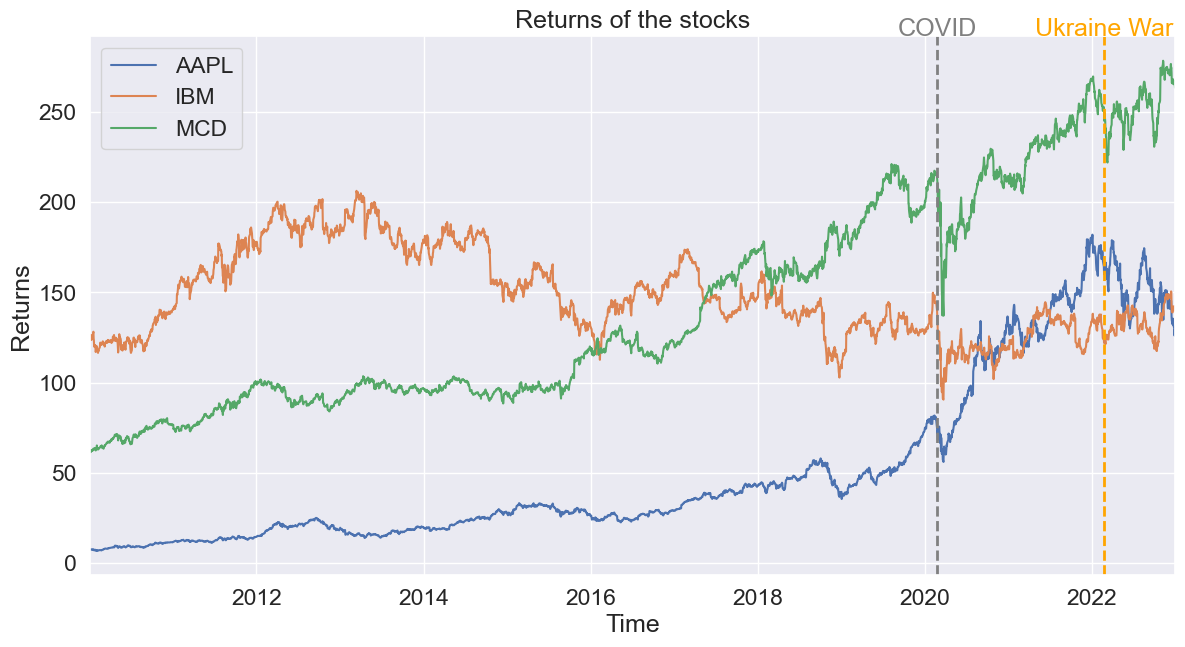

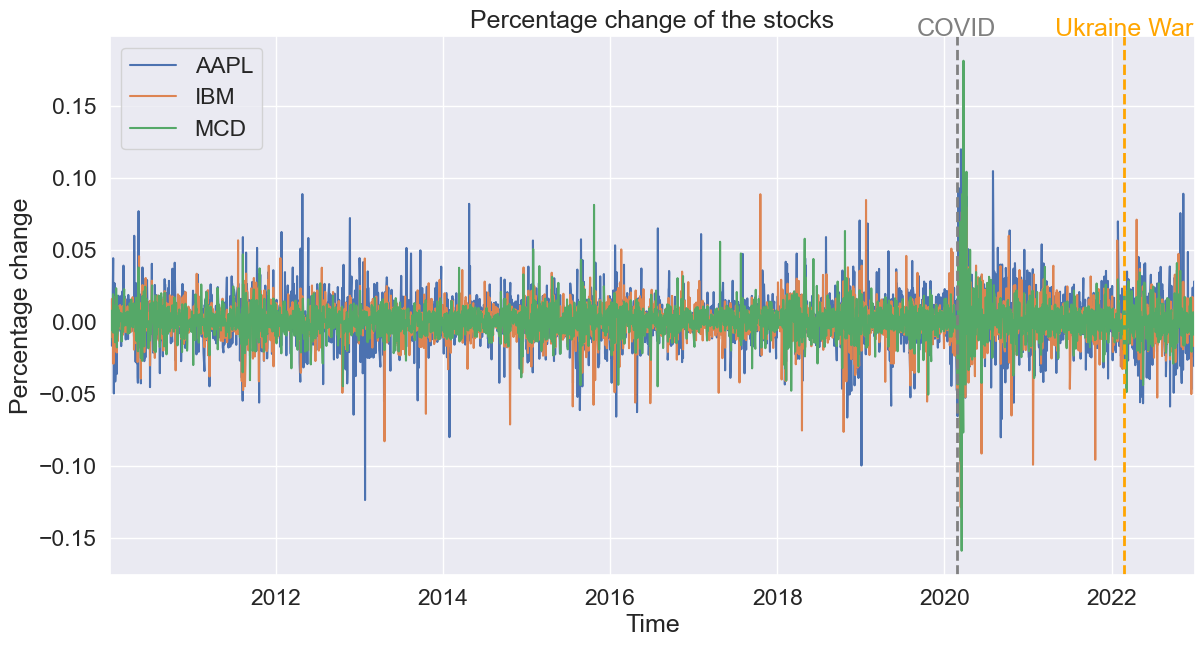

In [43]:
# Plot the returns of the stocks with highlights and annotations
plt.figure(figsize=(14, 7))
plt.plot(stocksPrices)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Returns of the stocks")
plt.xlabel("Time")
plt.ylabel("Returns")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

plt.xlim(left=stocksPrices.index[0], right=stocksPrices.index[-1])
plt.show()


# Plot also the percentage change of the stocks with highlights and annotations
plt.figure(figsize=(14, 7))
plt.plot(stocksPercentageChangeReturn)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Percentage change of the stocks")
plt.xlabel("Time")
plt.ylabel("Percentage change")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

plt.xlim(left=stocksPercentageChangeReturn.index[0], right=stocksPercentageChangeReturn.index[-1])
plt.show()

# Dictionary Initialization

In [44]:
prescientDict = {}
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
rwValues = []
rwMeanRegretValues = []
rwMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

days_greater_than_one_values = []  # To store determinant values where > 1
days_less_than_one_values = []  # To store determinant values where < 1

aaplModifiedVolatility = {}
ibmModifiedVolatility = {}
mcdModifiedVolatility = {}

# Covariance Predictors

PRESCIENT(GROUND TRUTH)

In [45]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1  
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

In [46]:
# NOW I IMPLEMENT AN EXPANDING WINDOW MODEL FOR EVERY QUARTER
# empirical covariance matrix using paper formula
expandingWindowDict = {}

empCovarianceMatrixList = []
quarterCovarianceMatrixList = []
tempQuarter = 1 # the first quarter has index 1

# Initialize an empty DataFrame to hold all empirical covariance matrices
all_empirical_cov_matrices = pd.DataFrame()


for t in uniformlyDistributedReturns.index:

    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1

    # if the quarter changes, i have to reset the list of the covariance matrices
    if quarter != tempQuarter:
        quarterCovarianceMatrixList = []
        tempQuarter = quarter

    # get the percentage change of the stocks for the current day
    today_returns = uniformlyDistributedReturns.loc[t]

    # multiply the returns by the transpose of the returns
    covariance_matrix = np.outer(today_returns, today_returns.T) # covariance matrix at time t

    assert(covariance_matrix.shape == (3, 3))

    # truncate every element of the covariance matrix to 6 decimals
    covariance_matrix = covariance_matrix.round(6)

    # add the covariance matrix to the list
    quarterCovarianceMatrixList.append(covariance_matrix) # this is the list of the covariance matrix for the current quarter

    # sum all the covariance matrices for the quarter(sum all the matrices contained in the list)
    quarterCovarianceMatricesSum = sum(quarterCovarianceMatrixList)

    # take the average of the covariance matrices; divide the sum of the matrices by the lenght of the quarter (so the lenght of the list)
    empirical_cov_matrix = quarterCovarianceMatricesSum / len(quarterCovarianceMatrixList)

    # truncate every element of the covariance matrix to 6 decimals
    empirical_cov_matrix = empirical_cov_matrix.round(6)

    # Convert the empirical covariance matrix to a DataFrame for this specific date
    expandingWindowDict[t] = pd.DataFrame(empirical_cov_matrix, index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

    # add the empirical covariance matrix to the list
    empCovarianceMatrixList.append(empirical_cov_matrix)

print("dimension of dataset: " + str(uniformlyDistributedReturns.shape))

print("len of the empirical covariance matrix list: " + str(len(empCovarianceMatrixList)))

print("len of the expanding window dictionary: " + str(len(expandingWindowDict)))



# print just the first key and value of the dictionary
print(list(expandingWindowDict.keys())[0])
print(expandingWindowDict[list(expandingWindowDict.keys())[0]])


dimension of dataset: (3272, 3)
len of the empirical covariance matrix list: 3272
len of the expanding window dictionary: 3272
2010-01-04 00:00:00
          7         20990     21177
7      0.000242  0.000184  0.000085
20990  0.000184  0.000140  0.000064
21177  0.000085  0.000064  0.000030


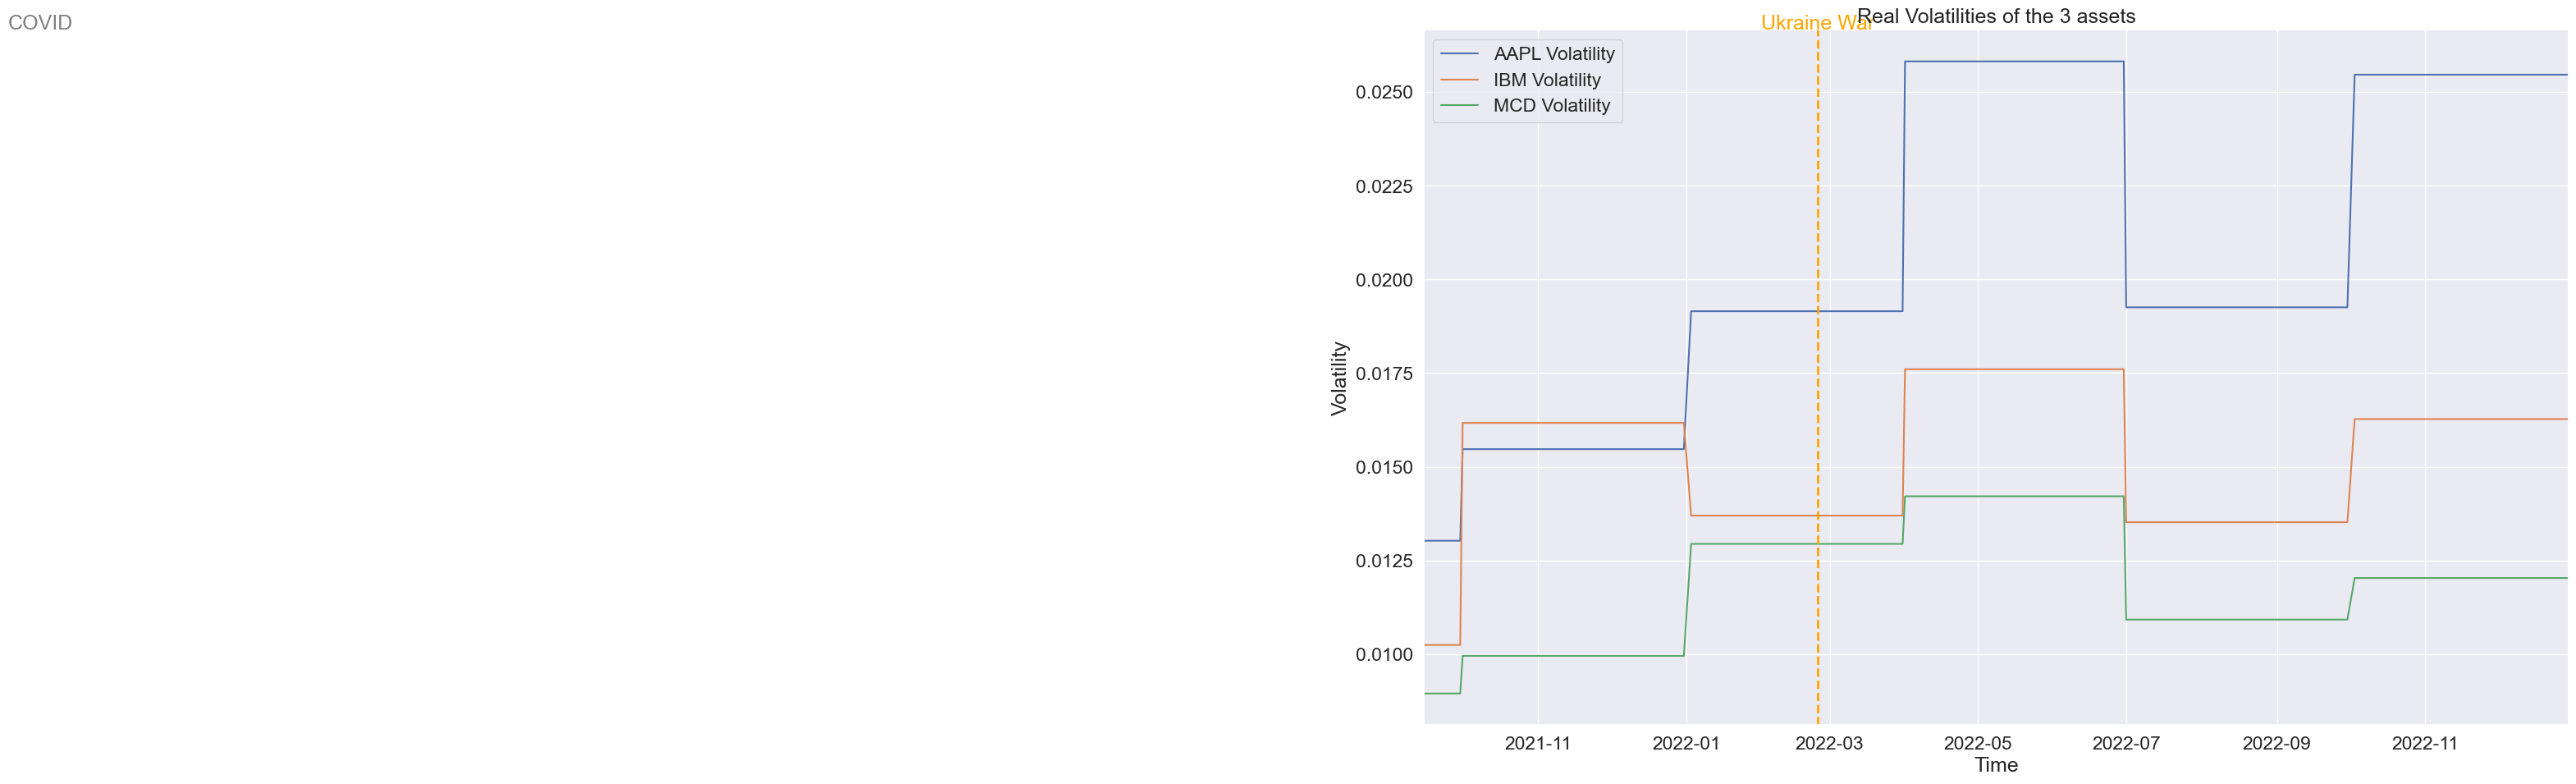

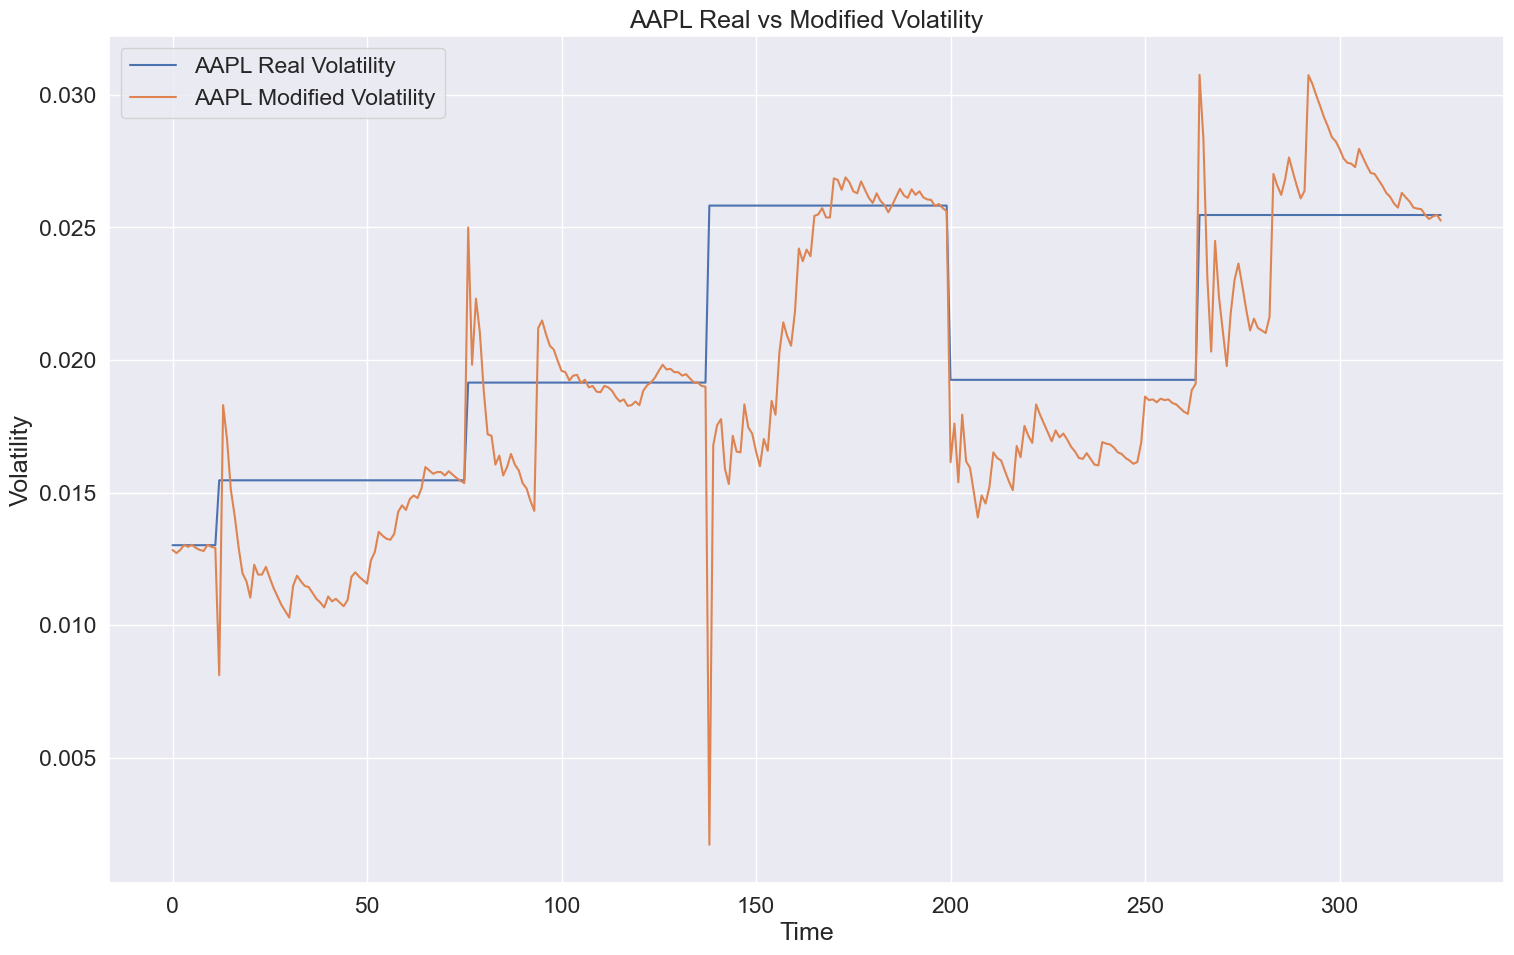

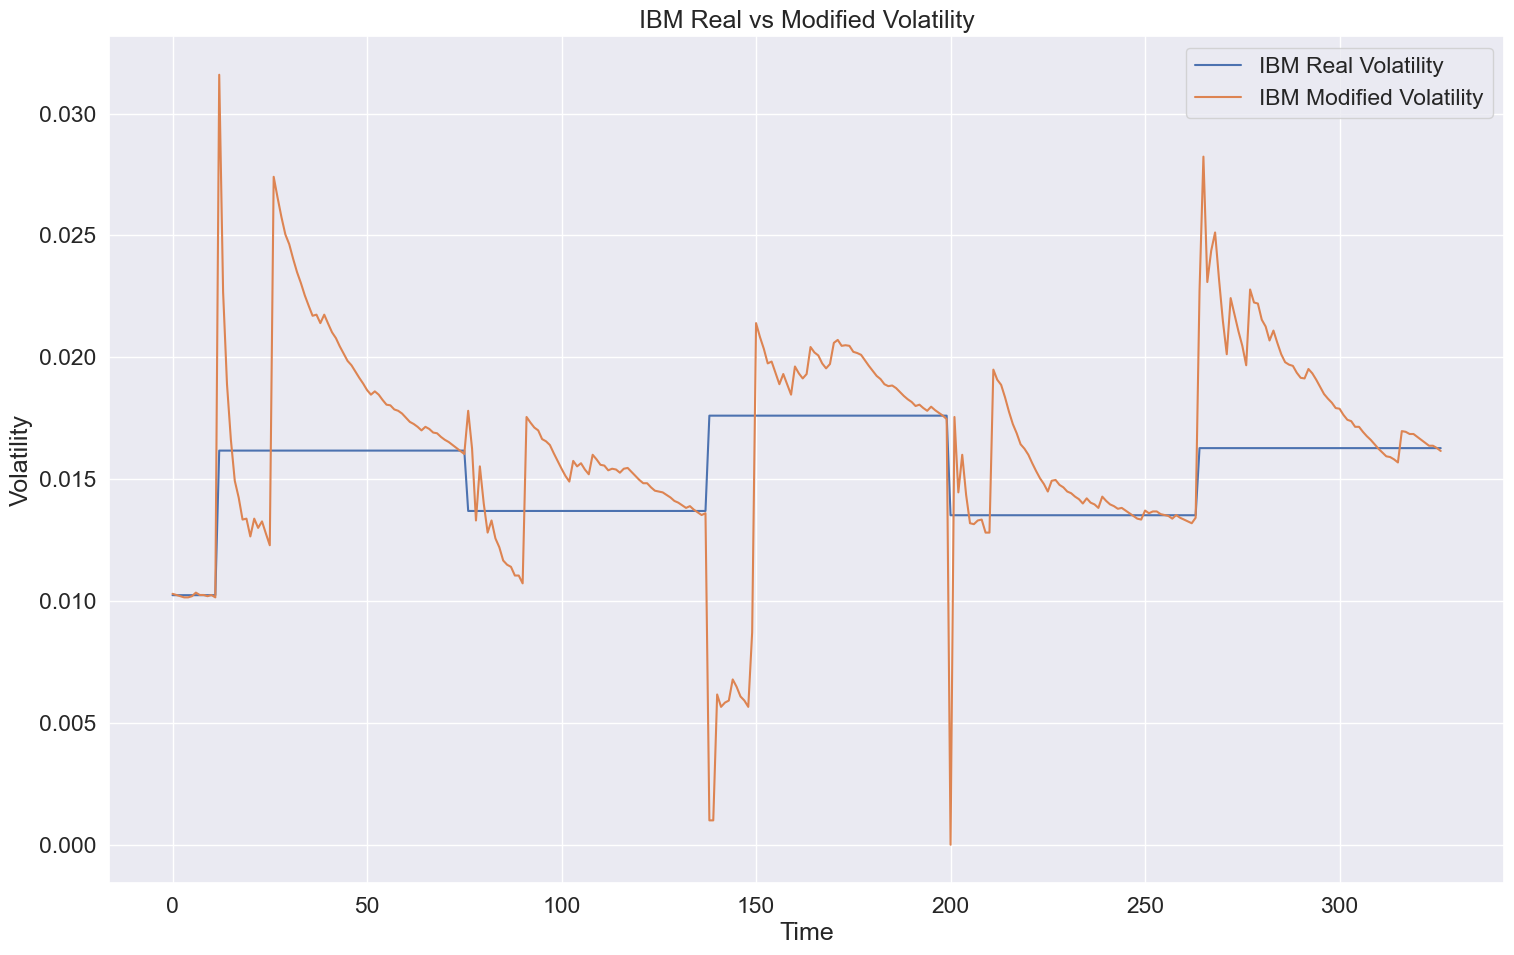

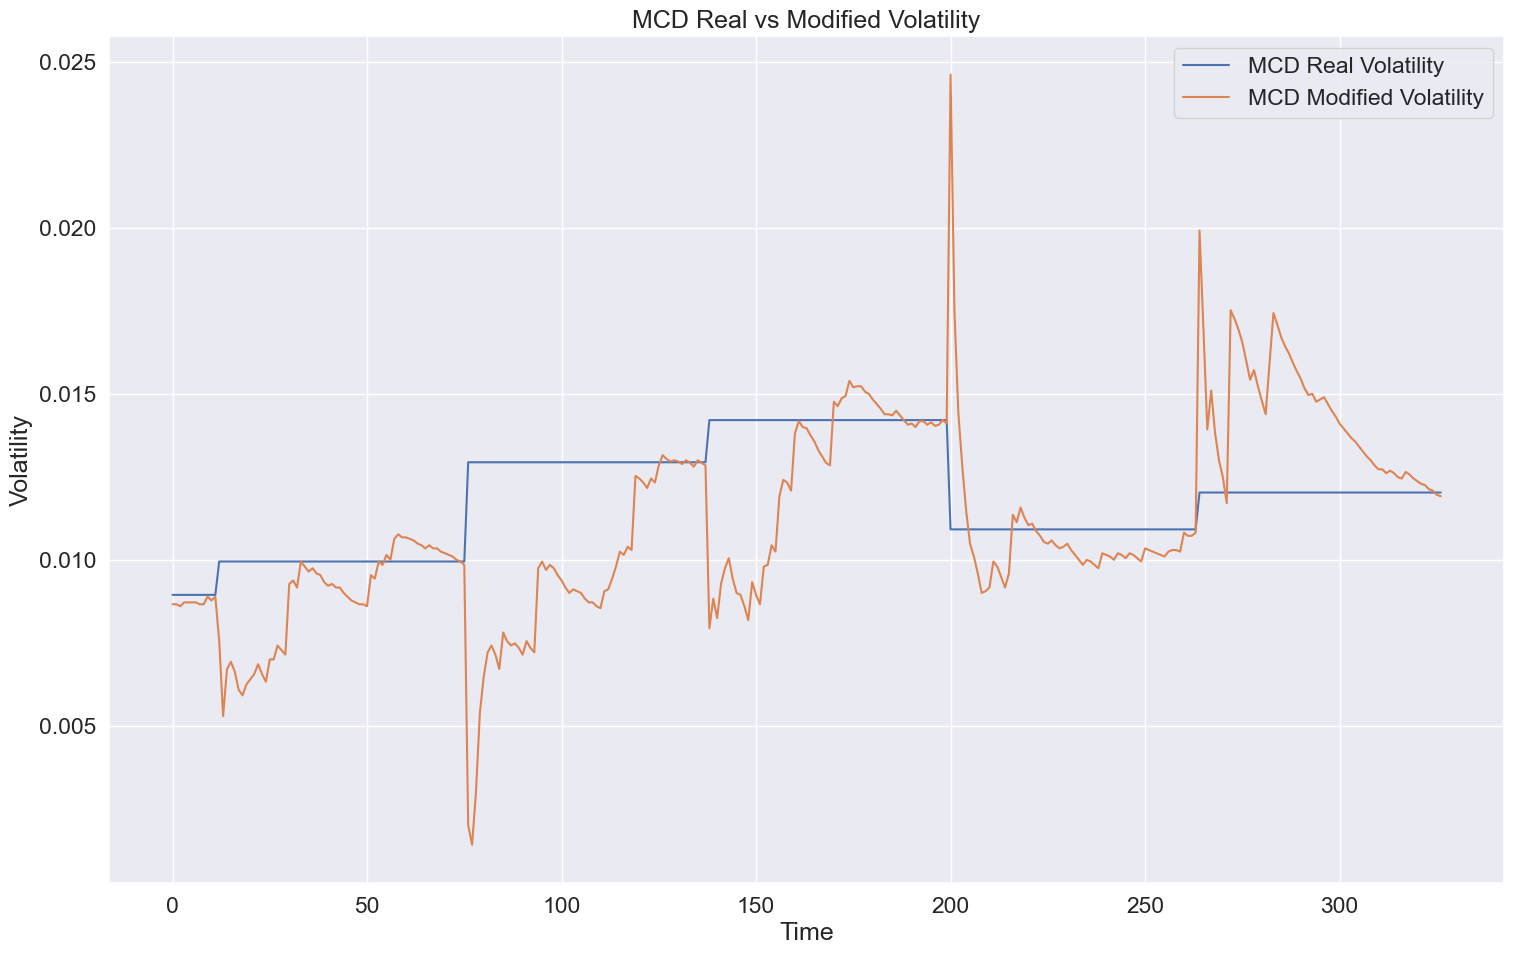

In [47]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

ew_volatilities = {}

for date, cov_matrix in expandingWindowDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    ew_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])


# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

ew_volatilities = {k: v for k, v in ew_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}

# now calculates/extract the real volatilities of the 3 assets
ew_volatility_dict_aapl = {}
ew_volatility_dict_ibm = {}
ew_volatility_dict_mcd = {}

for date, volatilities in ew_volatilities.items():
    ew_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    ew_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    ew_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_ew_volatility_aapl = pd.DataFrame(list(ew_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_ew_volatility_ibm = pd.DataFrame(list(ew_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_ew_volatility_mcd = pd.DataFrame(list(ew_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_ew_volatility_aapl.set_index('Date', inplace=True)
df_ew_volatility_ibm.set_index('Date', inplace=True)
df_ew_volatility_mcd.set_index('Date', inplace=True)



real_voltilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_voltilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

real_voltilities = {k: v for k, v in real_voltilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_voltilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_volatility_aapl.index[0], right=df_volatility_aapl.index[-1])
plt.show()


##################################################################################
# now save every volatility value in a vector. This vector will contain only the value of the apple volatility, without timestamp
aapl_real_volatility = df_volatility_aapl["AAPL Volatility"].values
real_volatility_startDate = df_volatility_aapl.index[0]
real_volatility_endDate = df_volatility_aapl.index[-1]

ibm_real_volatility = df_volatility_ibm["IBM Volatility"].values
mcd_real_volatility = df_volatility_mcd["MCD Volatility"].values

# now do the same thing with the volatilities calculated using the expanding window matrix
aapl_ew_volatility = df_ew_volatility_aapl["AAPL Volatility"].values
ew_volatility_startDate = df_ew_volatility_aapl.index[0]
ew_volatility_endDate = df_ew_volatility_aapl.index[-1]

ibm_ew_volatility = df_ew_volatility_ibm["IBM Volatility"].values
mcd_ew_volatility = df_ew_volatility_mcd["MCD Volatility"].values


# plot 3 charts to compare the real volatilities with the modified volatilities
plt.figure(figsize=(18, 11))
plt.plot(aapl_real_volatility, label='AAPL Real Volatility')
plt.plot(aapl_ew_volatility, label='AAPL Modified Volatility')
plt.legend()
plt.title("AAPL Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(ibm_real_volatility, label='IBM Real Volatility')
plt.plot(ibm_ew_volatility, label='IBM Modified Volatility')
plt.legend()
plt.title("IBM Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(mcd_real_volatility, label='MCD Real Volatility')
plt.plot(mcd_ew_volatility, label='MCD Modified Volatility')
plt.legend()
plt.title("MCD Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.show()

##################################################################################

ok everything works fine; at the moment i will not tune the model(there aren't parameters or hyperparameters), i just measure its performance. so i will use just the test dataset in order to have a fair evaluation of the model with respect to the performance of the other models(RW,EWMA,MGARCH) 

# Test Phase for expanding window predictor

c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:207: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2


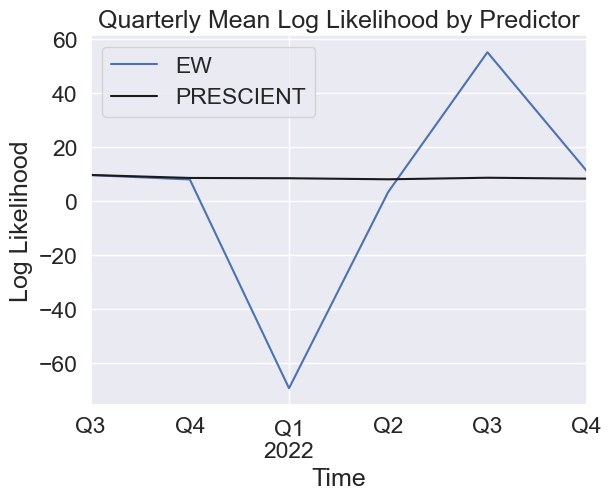



meanRegret: 5.600
stdRegret: 36.600
maxRegret: 77.800


meanLoglikelihoodEW: 3.100
stdLoglikelihoodEW: 36.700
maxLoglikelihoodEW: 55.200


meanLoglikelihoodPRESCIENT: 8.700
stdLoglikelihoodPRESCIENT: 0.500
maxLoglikelihoodPRESCIENT: 9.800

EW MSE
mean: 0.0000016054
std: 0.0000010503
max: 0.0000031789


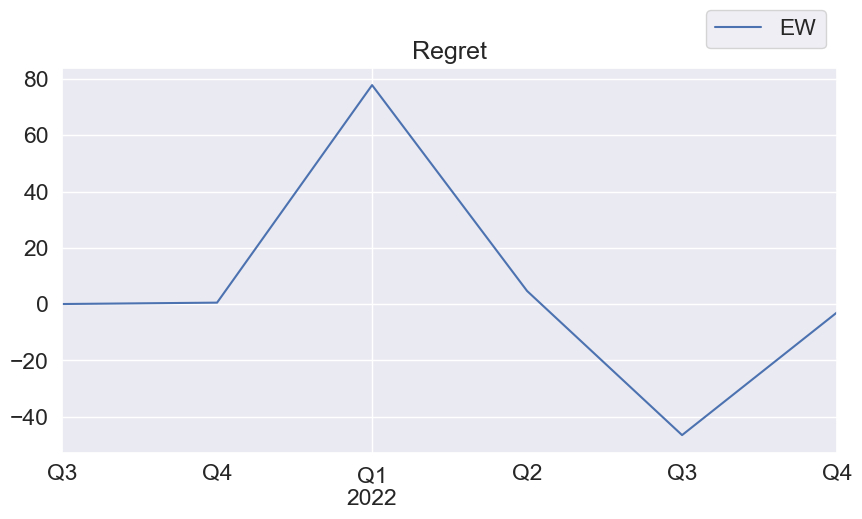

In [48]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [expandingWindowDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        rwMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(testDataWithPercentageChange, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")
